In [2]:
!pip install -q kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c predictingbookratingsint20h
!unzip train.csv.zip
!unzip test.csv.zip

  0% 0.00/25.5k [00:00<?, ?B/s]
100% 25.5k/25.5k [00:00<00:00, 9.88MB/s]
  0% 0.00/1.65M [00:00<?, ?B/s]
100% 1.65M/1.65M [00:00<00:00, 54.0MB/s]
 29% 5.00M/17.5M [00:00<00:00, 44.8MB/s]
100% 17.5M/17.5M [00:00<00:00, 85.5MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
train = pd.read_csv('./train.csv', index_col='id')
test = pd.read_csv('./test.csv', index_col='id')

In [5]:
train.head(3)

,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count,book_rating
id,,,,,,,,,,
0,Forastera,https://images.gr-assets.com/books/1500683049l...,"Recién acabada la Segunda Guerra Mundial, una ...",Historical|Historical Fiction|Romance|Fantasy|...,Diana Gabaldon|Carmen Bordeu,Kindle Edition,768 pages,40197,668892,4.22
1,Writing about Magic,https://images.gr-assets.com/books/1445900480l...,Do you write fantasy fiction? This book is a r...,Language|Writing|Nonfiction,Rayne Hall,Paperback,180 pages,27,126,3.95
2,The Stress of Her Regard,https://images.gr-assets.com/books/1503059955l...,When Michael Crawford discovers his bride brut...,Fantasy|Horror|Paranormal|Vampires|Historical|...,Tim Powers,Paperback,470 pages,331,3626,3.79


In [53]:
train['book_genre'] = train['book_genre'].fillna('nan')
test['book_genre'] = test['book_genre'].fillna('nan')

In [7]:
def get_genres(df):
  genres = list(df['book_genre'])
  genres = list(map(lambda x: x.split('|'), genres))
  genres = [item for sublist in genres for item in sublist]
  genres = np.array(genres)
  genres_unique, unique_counts = np.unique(genres, return_counts=True)
  return genres, dict(zip(genres_unique, unique_counts))

In [54]:
train_genres, train_genres_unique = get_genres(train)

(array([831.,  10.,   6.,   3.,   2.,   0.,   0.,   1.,   1.,   1.]),
 array([1.00000e+00, 1.85040e+03, 3.69980e+03, 5.54920e+03, 7.39860e+03,
        9.24800e+03, 1.10974e+04, 1.29468e+04, 1.47962e+04, 1.66456e+04,
        1.84950e+04]),
 <a list of 10 Patch objects>)

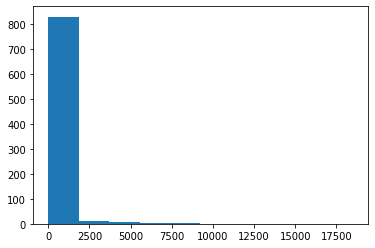

In [9]:
plt.hist(train_genres_unique.values())

In [13]:
def process(init_df, genres_unique, threshold = 2000):
  df = init_df.copy()
  top_genres = [g for g in genres_unique.keys() if genres_unique[g] > threshold] + ['Other']
  for genre in top_genres:
        df[f'genre_({genre})'] = np.zeros((len(df)))
  for i in range(len(df)):
    genres_list = df.iloc[i]['book_genre'].split('|')
    for genre in genres_list:
      if genre in top_genres:
        df.at[i, f'genre_({genre})'] = 1
  df['book_pages'] = df['book_pages'].astype(str).apply(lambda x: int(x.split()[0]) if x.split()[0] != 'nan' else 0)
  df = df.drop(columns=['book_genre', 'book_image_url'])
  return df

In [55]:
threshold = 2000
train_processed = train.copy() 
train_processed = process(train_processed, train_genres_unique, threshold)

test_processed = test.copy() 
test_processed = process(test_processed, train_genres_unique, threshold)

In [56]:
train_processed['book_format'] = train_processed['book_format'].fillna('nan')
test_processed['book_format'] = test_processed['book_format'].fillna('nan')

In [16]:
formats = ['soft_cover', 'hard_cover', 'ebook', 'audio', 'other']
def proc_formats(init_df, formats):
  df = init_df.copy()
  for format in formats:
        df[f'format_({format})'] = np.zeros((len(df)))
  for i in range(len(df)):
    formats_list = df.iloc[i]['book_format']
    if any([format in formats_list.lower() for format in ['paper', 'soft']]):
      df.at[i, 'format_(soft_cover)'] = 1
    elif any([format in formats_list.lower() for format in ['hard']]):
      df.at[i, 'format_(hard_cover)'] = 1
    elif any([format in formats_list.lower() for format in ['ebook', 'kindle', 'nook', 'digital']]):
      df.at[i, 'format_(ebook)'] = 1
    elif any([format in formats_list.lower() for format in ['audio', 'cd']]):
      df.at[i, 'format_(audio)'] = 1
    else:
      df.at[i, 'format_(other)'] = 1
  df = df.drop(columns=['book_format'])
  return df

In [57]:
train_processed = proc_formats(train_processed, formats)
test_processed = proc_formats(test_processed, formats)

In [58]:
train_processed['authors_number'] = train_processed['book_authors'].apply(lambda x: len(x.split('|')))
train_processed = train_processed.drop(columns=['book_authors'])
test_processed['authors_number'] = test_processed['book_authors'].apply(lambda x: len(x.split('|')))
test_processed = test_processed.drop(columns=['book_authors'])

In [59]:
train_processed['title_len'] = train_processed['book_title'].apply(lambda x: len(x.split(' ')))
train_processed = train_processed.drop(columns=['book_title'])
test_processed['title_len'] = test_processed['book_title'].apply(lambda x: len(x.split(' ')))
test_processed = test_processed.drop(columns=['book_title'])

In [20]:
!pip install -q ktrain

     |████████████████████████████████| 25.3MB 1.3MB/s 
     |████████████████████████████████| 6.8MB 53.8MB/s 
     |████████████████████████████████| 983kB 46.0MB/s 
     |████████████████████████████████| 266kB 60.1MB/s 
     |████████████████████████████████| 1.3MB 46.8MB/s 
     |████████████████████████████████| 1.2MB 18.8MB/s 
     |████████████████████████████████| 471kB 57.4MB/s 
     |████████████████████████████████| 2.9MB 45.5MB/s 
     |████████████████████████████████| 890kB 43.6MB/s 
ERROR: transformers 3.5.1 has requirement sentencepiece==0.1.91, but you'll have sentencepiece 0.1.95 which is incompatible.


In [21]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [22]:
import ktrain
from ktrain import text, tabular

In [62]:
trn_text, val_text, preproc_text = text.texts_from_array(x_train=train_processed['book_desc'].to_numpy(), 
                                                         y_train=train_processed['book_rating'].to_numpy(),
                                          preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:581: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  'If this is incorrect, change accordingly.')


task: text regression (supply class_names argument if this is supposed to be classification task)


In [64]:
model_text = text.text_regression_model('bert', train_data=trn_text, preproc=preproc_text)
learner_text = ktrain.get_learner(model_text, train_data=trn_text, val_data=val_text, batch_size=12)

maxlen is 400
done.


In [69]:
learner_text.autofit(lr=1e-3, epochs=1)



begin training using triangular learning rate policy with max lr of 0.001...
3000/3000 [==============================] - 4430s 1s/step - loss: 0.2622 - mean_absolute_error: 0.2945 - val_loss: 0.1529 - val_mean_absolute_error: 0.2656


In [70]:
predictor_text = ktrain.get_predictor(learner_text.model, preproc_text)

In [72]:
train_processed['text_regr'] = predictor_text.predict(train_processed['book_desc'].to_numpy())
train_processed = train_processed.drop(columns = ['book_desc'])

test_processed['text_regr'] = predictor_text.predict(test_processed['book_desc'].to_numpy())
test_processed = test_processed.drop(columns = ['book_desc'])

In [74]:
trn, val, preproc = tabular.tabular_from_df(train_processed, is_regression=True, 
                                             label_columns='book_rating')

processing train: 35959 rows x 35 columns
processing test: 4041 rows x 35 columns


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:581: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  'If this is incorrect, change accordingly.')


In [75]:
model = tabular.tabular_regression_model('mlp', trn, metrics=['mae'])
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=128)

done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/16
280/280 [==============================] - 4s 14ms/step - loss: 17.6210 - mae: 4.1778
Epoch 2/16
280/280 [==============================] - 4s 14ms/step - loss: 16.8055 - mae: 4.0786
Epoch 3/16
280/280 [==============================] - 4s 14ms/step - loss: 14.3498 - mae: 3.7642
Epoch 4/16
280/280 [==============================] - 4s 14ms/step - loss: 8.4792 - mae: 2.8416
Epoch 5/16
280/280 [==============================] - 4s 14ms/step - loss: 1.6677 - mae: 1.0344
Epoch 6/16
280/280 [==============================] - 4s 14ms/step - loss: 0.4738 - mae: 0.4494
Epoch 7/16
280/280 [==============================] - 4s 14ms/step - loss: 0.2140 - mae: 0.3059
Epoch 8/16
280/280 [==============================] - 4s 14ms/step - loss: 0.1541 - mae: 0.2641
Epoch 9/16
280/280 [==============================] - 4s 14ms/step - loss: 0.1465 - mae: 0.2608
Epoch 10/16
280/280 [=============================

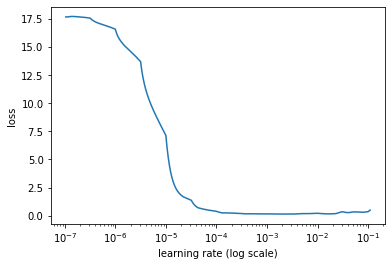

In [76]:
learner.lr_find(show_plot=True, max_epochs=16)

In [77]:
learner.autofit(lr=5e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
281/281 [==============================] - 6s 20ms/step - loss: 4.6231 - mean_absolute_error: 1.6104 - val_loss: 0.7598 - val_mean_absolute_error: 0.5425
Epoch 2/1024
281/281 [==============================] - 5s 19ms/step - loss: 0.4100 - mean_absolute_error: 0.4160 - val_loss: 0.3651 - val_mean_absolute_error: 0.3527
Epoch 3/1024
281/281 [==============================] - 6s 20ms/step - loss: 0.2403 - mean_absolute_error: 0.3245 - val_loss: 0.2972 - val_mean_absolute_error: 0.3207
Epoch 4/1024
281/281 [==============================] - 6s 20ms/step - loss: 0.2002 - mean_absolute_error: 0.2995 - val_loss: 0.2579 - val_mean_absolute_error: 0.3018
Epoch 5/1024
281/281 [==============================] - 6s 20ms/step - loss: 0.1785 - mean_absolute_error: 0.2852 - val_loss: 0.2113 - val_mean_abso

In [78]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [79]:
preds = predictor.predict(test_processed)

In [80]:
preds.flatten()

array([3.723648 , 3.68085  , 4.0112605, ..., 3.805924 , 3.8146253,
       3.9419663], dtype=float32)

In [81]:
sub = pd.read_csv('./submission.csv', index_col = 'id')
sub['book_rating'] = preds.flatten()

In [82]:
sub.to_csv('./my_sub_new_2.csv')

In [294]:
# Saving Json file
model_json = learner.model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# Saving Weights
learner.model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
